This notebook is used to develop and implement the utility functions that will allow us do perform our experiments and store the results appropriately.

The experiments will test for the following:
* The role of hyperparameters
* The interplay between hyperparameters
* The interplay between features and hyperparameters
* The presence of unnecessary features
* The absence of necessary features
* The role of the number of instances and how this affects the tests above (we have 100k entries in our simulated dataset, we will test for 10k, 1k, and 100 too)
* The role of the cleaning process on everything mentioned.

All the experiments will be run on different targets, some with a linear relation with the features, some with a non-linear one. Each algorithm will be tested and we will record the results of each of the above experiments.

Each run will have thus to record
* Score under various metrics on both the train and test sets.
* Plot of the predicted values vs the real one
* Plot of the estimated coefficients vs the real one (when possible)
* Learning curves (when necessary)

We will make extensive use of Pipelines, as they make it easier to iterate quickly on different configurations. To know more about this, you can refer to my Kaggle kernel https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline

First, let's get some data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pickle
from datetime import date
from os.path import exists

from sklearn.model_selection import KFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge  # just a random model to test stuff
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error

from sklearn.base import BaseEstimator, TransformerMixin

import source.transf_univ as df_p
from source.report import plot_predictions, _plot_diagonal
from source.utility import cv_score, grid_search

%matplotlib inline
pd.set_option('max_columns', 500)

In [2]:
df = pd.read_csv('data/simulated/clean.csv')

df.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,tar_lin_full,tar_lin_unc,tar_lin_corr,tar_lin_3,tar_lin_3int,tar_nonlin_full,tar_nonlin_unc,tar_nonlin_corr,tar_nonlin_3,tar_nonlin_3int
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,83.127530,17.975525,-94.548065,0.682160,0.060012,3.244956,-8.150569,2.331188,6.405137,-1.148288
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,44.611882,15.378844,-82.392359,0.321245,-0.970262,1.898439,10.561064,3.252234,23.120533,8.666193
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,59.912546,28.101300,-76.892632,0.318452,0.621707,0.265541,2.744933,3.691036,267.479799,263.880632
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,22.010211,9.388242,-7.545897,2.646304,66.691221,24.317470,-88.730236,0.774157,-0.322802,3.882116,9.270183,3.651130,367.342161,354.587015
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.417453,6.868044,-7.087807,4.464484,29.737370,20.812954,-67.718221,0.612704,1.681971,3.378512,-6.859040,1.986998,40.236153,50.003422


# Testing the role of the hyperparameters

This is done in 2 steps:
* Generating train and test score for each hyperparameter choice
* Plotting appropriately the results

Luckily, pipelines and grid searches work well together for the first point and the `source.utility.grid_search` function will do the job just fine.

In [3]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median'))])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('ridge', Ridge())])

kfolds = KFold(5, shuffle=True, random_state=541)

In [4]:
df_train = df[[col for col in df.columns if not col.startswith('tar_')]].copy()

target = df['tar_lin_unc']  # a random one to test stuff

df_train.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,22.010211,9.388242,-7.545897,2.646304
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.417453,6.868044,-7.087807,4.464484


In [5]:
param_grid = {'ridge__alpha': np.arange(1, 5, 0.5), 'ridge__tol': np.arange(0.0001, 0.002, 0.0001)}

res, bp, _ = grid_search(df_train, target, model, param_grid, 'neg_mean_squared_error', kfolds)

print(bp)
res

{'ridge__alpha': 1.0, 'ridge__tol': 0.0001}


,param_ridge__alpha,param_ridge__tol,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,1,0.0001,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.610875,0.248025,0.070120,0.010455
1,1,0.0011,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.362880,0.077614,0.068493,0.008969
2,1,0.0002,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.628100,0.088351,0.081073,0.012497
3,1,0.0019,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.315207,0.104619,0.061598,0.014619
4,1,0.0018,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.363576,0.138966,0.062423,0.005241
...,...,...,...,...,...,...,...,...,...,...
147,4.5,0.0004,-8.671326e-08,1.390717e-10,-8.690329e-08,1.300057e-09,1.384620,0.176003,0.061181,0.012072
148,4.5,0.0003,-8.671326e-08,1.390717e-10,-8.690329e-08,1.300057e-09,1.385076,0.228514,0.069987,0.006808
149,4.5,0.0002,-8.671326e-08,1.390717e-10,-8.690329e-08,1.300057e-09,1.404726,0.178971,0.068742,0.008430
150,4.5,0.0001,-8.671326e-08,1.390717e-10,-8.690329e-08,1.300057e-09,1.521936,0.216475,0.082761,0.012103


Next, we need to plot appropriately the scores and the times.

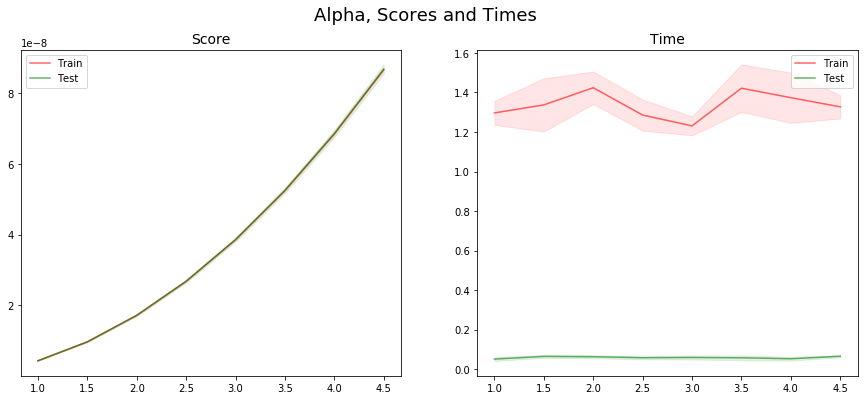

In [6]:
def plot_hyperparameter(result, param_name, pretty_name, negative=True):
    
    if negative:
        res = result.copy()
        res['mean_train_score'] = -res['mean_train_score']
        res['mean_test_score'] = -res['mean_test_score']
    else:
        res = result.copy()

    fig, ax = plt.subplots(1,2, figsize=(15,6))

    X_axis = res[param_name].astype(float)

    ax[0].plot(X_axis, res['mean_train_score'], label='Train', color='r', alpha=.6)
    ax[0].fill_between(X_axis, (res['mean_train_score'] - res['std_train_score']).astype(float),
                            (res['mean_train_score'] + res['std_train_score']).astype(float), alpha=0.1, color='r')
    ax[0].plot(X_axis, res['mean_test_score'], label='Test', color='g', alpha=.6)
    ax[0].fill_between(X_axis, (res['mean_test_score'] - res['std_test_score']).astype(float),
                            (res['mean_test_score'] + res['std_test_score']).astype(float), alpha=0.1, color='g')

    ax[1].plot(X_axis, res['mean_fit_time'], label='Fit', color='r', alpha=.6)
    ax[1].fill_between(X_axis, (res['mean_fit_time'] - res['std_fit_time']).astype(float),
                            (res['mean_fit_time'] + res['std_fit_time']).astype(float), alpha=0.1, color='r')
    ax[1].plot(X_axis, res['mean_score_time'], label='Score', color='g', alpha=.6)
    ax[1].fill_between(X_axis, (res['mean_score_time'] - res['std_score_time']).astype(float),
                            (res['mean_score_time'] + res['std_score_time']).astype(float), alpha=0.1, color='g')

    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Score', fontsize=14)
    ax[1].set_title('Time', fontsize=14)
    fig.suptitle(f'{pretty_name}, Scores and Times', fontsize=18)

    plt.show()
    
    
plot_hyperparameter(res[res.param_ridge__tol == 0.001], 'param_ridge__alpha', 'Alpha')

Not so encouraging that we don't see much, but at least we see it works. 

Next, we want to plot the interplay among 2 different parameters. It makes sense to do so only on the test score and time

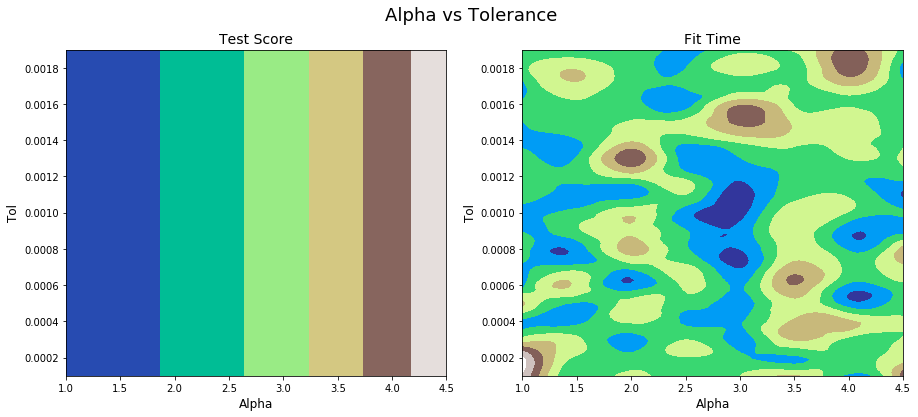

In [7]:
def plot_two_hyperparms(result, param_x, param_y, pretty_name, negative=True):
    
    if negative:
        res = result.copy()
        res['mean_test_score'] = -res['mean_test_score']
    else:
        res = result.copy()

    fig, ax = plt.subplots(1,2, figsize=(15,6))

    X_axis = res[param_x].astype(float)
    Y_axis = res[param_y].astype(float)

    xg, yg = np.meshgrid(np.linspace(X_axis.min(), X_axis.max(), 100),
                         np.linspace(Y_axis.min(), Y_axis.max(), 100))
    
    triangles = tri.Triangulation(X_axis, Y_axis)
    tri_interp = tri.CubicTriInterpolator(triangles, res['mean_test_score'])
    zg = tri_interp(xg, yg)
    
    ax[0].contourf(xg, yg, zg, 
                   norm=plt.Normalize(vmax=res['mean_test_score'].max(), vmin=res['mean_test_score'].min()),
                   cmap=plt.cm.terrain)
    
    tri_interp = tri.CubicTriInterpolator(triangles, res['mean_fit_time'])
    zg = tri_interp(xg, yg)
    
    ax[1].contourf(xg, yg, zg, 
                   norm=plt.Normalize(vmax=res['mean_fit_time'].max(), vmin=res['mean_fit_time'].min()), 
                   cmap=plt.cm.terrain)
    
    ax[0].set_xlabel(param_x.split('__')[-1].title(), fontsize=12)
    ax[1].set_xlabel(param_x.split('__')[-1].title(), fontsize=12)
    ax[0].set_ylabel(param_y.split('__')[-1].title(), fontsize=12)
    ax[1].set_ylabel(param_y.split('__')[-1].title(), fontsize=12)
    ax[0].set_title('Test Score', fontsize=14)
    ax[1].set_title('Fit Time', fontsize=14)
    fig.suptitle(f'{pretty_name}', fontsize=18)
    
    plt.show()
    
plot_two_hyperparms(res, 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

Once again we see that in this case only alpha matters and the lower the better. However we can see some interesting patterns in the fit time. 

# Features and hyperparameters

This function can be used to investigate also the interplay between features and parameters as we can build transformers to be plugged into our pipeline that modify or not our training set and, via the GridSearch, we can then explore the role of these transformers.

A simple example of how that would work is adding random noise to an important feature and see how it plays out with different `alpha`

In [8]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, noise=None):
        self.columns = []  # useful to well behave with FeatureUnion
        self.noise = noise
     
    
    def fit(self, X, y=None):
        return self
 

    def transform(self, X, y=None):
        X = X.copy()
        
        if not self.noise is None:
            X['unc_skewed_neg'] += np.random.normal(0, self.noise, X.shape[0])  # this feature has a high coefficient for this target

        self.columns = X.columns
        return X
    

    def get_feature_names(self):
        return self.columns

In [9]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median')), 
                         ('transformer', tr_numeric())])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('ridge', Ridge())])

In [10]:
param_grid = {'ridge__alpha': np.arange(1, 5, 0.5), 
              'processing__num_pipe__transformer__noise': np.arange(0, 30, 2)}

res_2, bp, _ = grid_search(df_train, target, model, param_grid, 'neg_mean_squared_error', kfolds)

print(bp)
res_2

{'processing__num_pipe__transformer__noise': 0, 'ridge__alpha': 1.0}


,param_processing__num_pipe__transformer__noise,param_ridge__alpha,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0,1,-4.282492e-09,6.868993e-12,-4.291878e-09,6.420632e-11,1.593993,0.084483,0.084882,0.010913
1,0,1.5,-9.635494e-09,1.545483e-11,-9.656610e-09,1.444623e-10,1.563336,0.083743,0.089617,0.006041
2,0,2,-1.712956e-08,2.747454e-11,-1.716710e-08,2.568184e-10,1.526478,0.182721,0.084899,0.004233
3,0,2.5,-2.676462e-08,4.292784e-11,-2.682328e-08,4.012735e-10,1.562638,0.237025,0.075383,0.014810
4,0,3,-3.854060e-08,6.181448e-11,-3.862506e-08,5.778261e-10,1.600302,0.241960,0.069387,0.018405
...,...,...,...,...,...,...,...,...,...,...
115,28,4.5,-9.001537e-03,1.555878e-05,-9.029767e-03,4.594877e-05,1.403115,0.075463,0.064281,0.021360
116,28,1.5,-9.003631e-03,9.639782e-06,-9.030359e-03,3.813263e-05,1.376944,0.204853,0.062417,0.015057
117,28,1,-9.004782e-03,1.071435e-05,-9.032053e-03,4.310748e-05,1.406793,0.089091,0.068580,0.018276
118,28,4,-9.004637e-03,9.176891e-06,-9.032190e-03,5.006699e-05,1.351759,0.160431,0.065200,0.018733


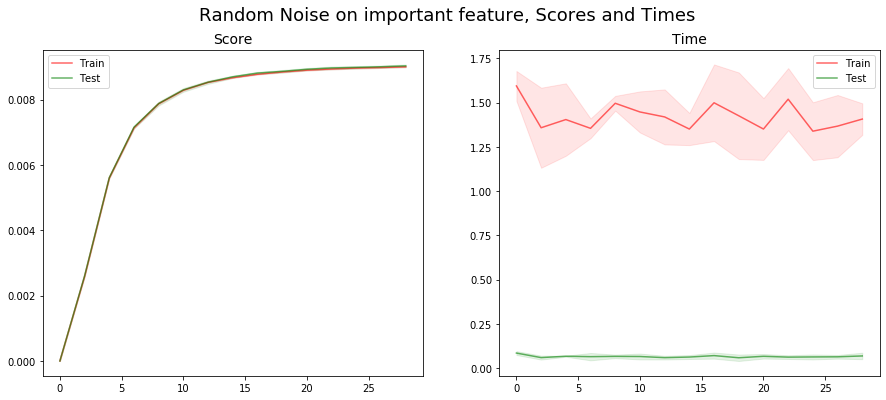

In [11]:
plot_hyperparameter(res_2[res_2.param_ridge__alpha == 1], 'param_processing__num_pipe__transformer__noise', 'Random Noise on important feature')

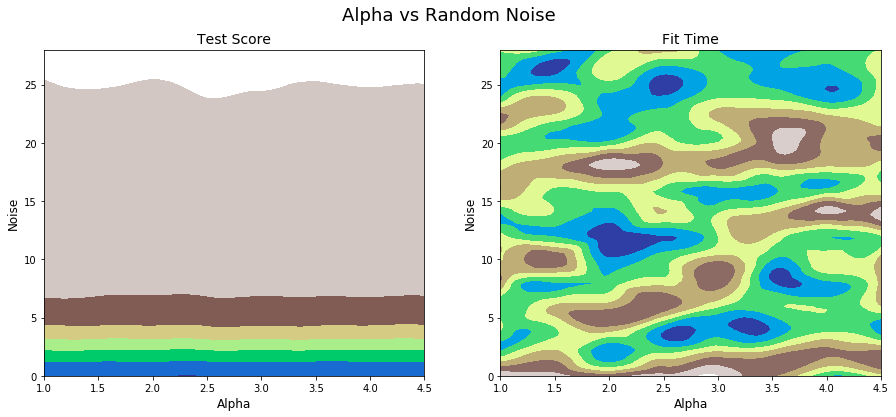

In [12]:
plot_two_hyperparms(res_2, 'param_ridge__alpha', 'param_processing__num_pipe__transformer__noise', 'Alpha vs Random Noise')

Naturally, in testing if we include or not certain features, these plot will be probably less interesting, but it is good to have the possibility.

# Analyzing models and predictions

Once that we pick an hyperparameters configuration, we can use the following to have a look at the predicted coefficients and at the predictions.

In [13]:
oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

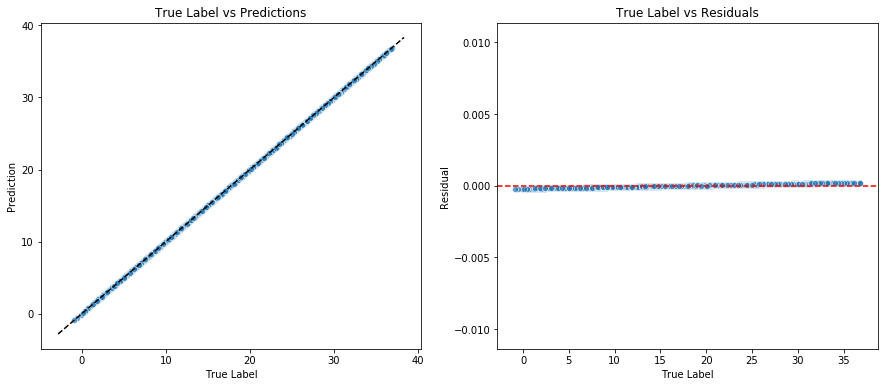

In [14]:
plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

We already knew we were learning the data very well, how about the coefficients? (I am adding a bit of std on the coefficient to test the error bars)

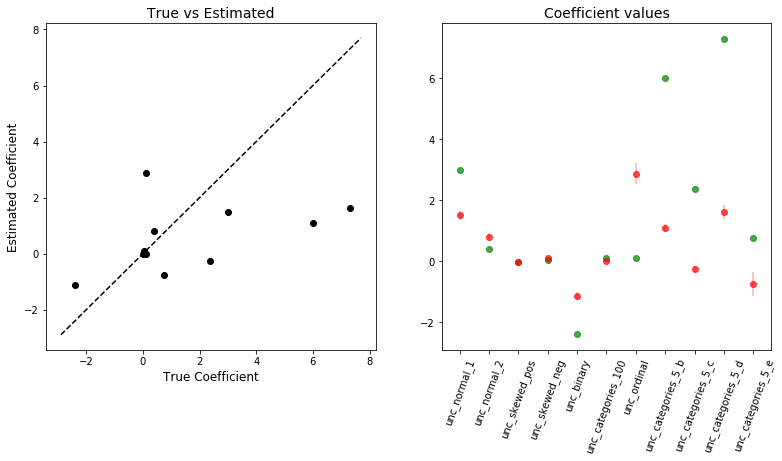

In [15]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))
    return ax

def plot_coefficients(target_name, est_coefs, annotate=False):
    coefs_real = pd.read_pickle('data/simulated/coefficients.pkl')
    coefs_real = coefs_real[target_name]
    
    comparison = pd.merge(coefs_real, coefs_est.reset_index(), on='feat', how='left').fillna(0)
    
    fig, ax = plt.subplots(1,2, figsize=(13,6))
    
    ax[0].scatter(comparison.coef, comparison['mean'], color='k')
    ax[0] = _plot_diagonal(ax[0])
    if annotate:
        ax[0] = label_point(comparison.coef, comparison['mean'], comparison.feat, ax[0])
        
    ax[0].set_xlabel('True Coefficient', fontsize=12)
    ax[0].set_ylabel('Estimated Coefficient', fontsize=12)
    ax[0].set_title('True vs Estimated', fontsize=14)
        
    ax[1].scatter(comparison.feat, comparison.coef, color='g', alpha=0.7)
    ax[1].scatter(comparison.feat, comparison['mean'], color='r', alpha=0.7)
    ax[1].errorbar(comparison.feat, comparison['mean'], yerr=comparison['std'], 
                   ls='none', color='r', alpha=0.3)
    
    ax[1].set_xticklabels(comparison.feat, rotation=70)
    ax[1].set_title('Coefficient values', fontsize=14)
    
    plt.show()
    
coefs_est['std'] = coefs_est['std'] * 200

plot_coefficients('tar_lin_unc', coefs_est, annotate=False)

We also want to appropriately store the results. For once, we want several metrics to be used.

In [16]:
def make_results(label, prediction, model, parameters, target_name, variables, instances, verbose=False):
    results=pd.DataFrame({'Date': [date.today().strftime("%d/%m/%Y")], 
                          'Model': [model],
                          'Parameters': [parameters], 
                          'Target': target_name, 
                          'Variables': variables, 
                          'N_instances': instances})
    
    results['MAE'] = mean_absolute_error(y_true=label, y_pred=prediction)
    results['MSE'] = mean_squared_error(y_true=label, y_pred=prediction)
    results['Max_error'] = max_error(y_true=label, y_pred=prediction)
    results['Explained_var'] = explained_variance_score(y_true=label, y_pred=prediction)

    if verbose:
        print(f'MAE: \t\t {round(results["MAE"].values[0], 5)}')
        print(f'MSE: \t\t {round(results["MSE"].values[0], 5)}')
        print(f'Max Error: \t {round(results["Max_error"].values[0], 5)}')
        print(f'Expl Variance: \t {round(results["Explained_var"].values[0], 5)}')
    
    return results


def store_results(file_loc, label, prediction, model, parameters, target_name, variables, instances, verbose=False):
    
    results = make_results(label, prediction, model, parameters, target_name, variables, instances, verbose)
    
    if not exists(file_loc):
        results.to_csv(file_loc, index=False)
    else:
        old_results = pd.read_csv(file_loc)
        results = pd.concat([old_results, results])
        results.to_csv(file_loc, index=False) 
    return

store_results('test.csv', target, oof, 'Ridge', {'alpha': 1}, 'tar_lin_unc', 'All', df_train.shape[0], verbose=True)

MAE: 		 5e-05
MSE: 		 0.0
Max Error: 	 0.00023
Expl Variance: 	 1.0


## Learning curves

Learning curves are a great instrument to get more information about how the model fits the data. They show how the model performs on train and test set if we vary the size of the training set.

We take full inspiration from this function in the sklearn documentation https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

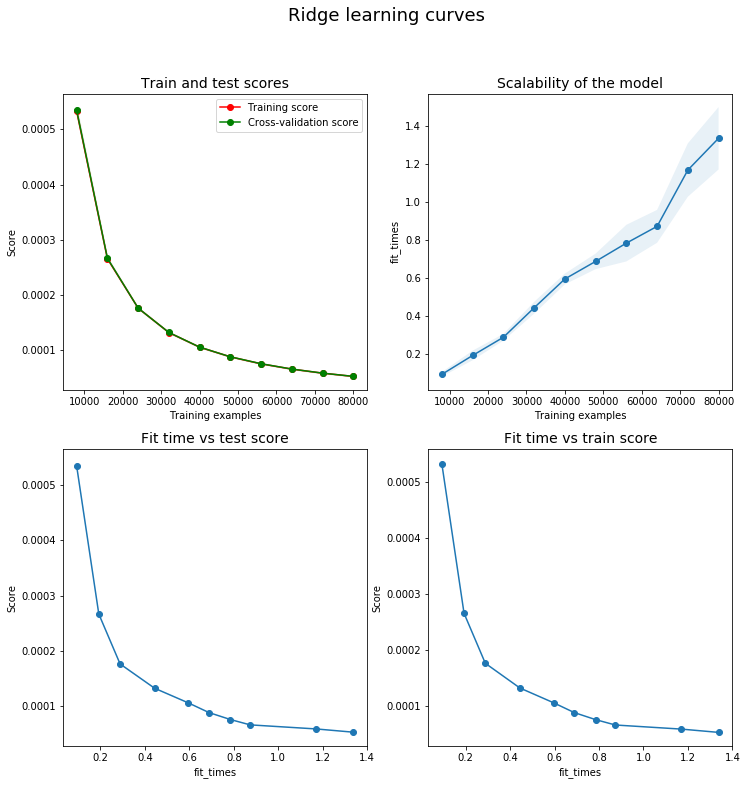

In [17]:
def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    train_sizes, train_scores, test_scores, fit_times, score_times = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       scoring=scoring,
                       train_sizes=train_sizes,
                       return_times=True)
    
    if not scoring is None:
        if 'neg' in scoring:
            train_scores = -train_scores
            test_scores = -test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    ax[0][0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax[0][0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax[0][0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax[0][0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax[0][0].legend(loc="best")
    ax[0][0].set_title('Train and test scores', fontsize=14)
    if ylim is not None:
        ax[0][0].set_ylim(*ylim)
    ax[0][0].set_xlabel("Training examples")
    ax[0][0].set_ylabel("Score")

    # Plot n_samples vs fit_times
    ax[0][1].plot(train_sizes, fit_times_mean, 'o-')
    ax[0][1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    ax[0][1].set_xlabel("Training examples")
    ax[0][1].set_ylabel("fit_times")
    ax[0][1].set_title("Scalability of the model", fontsize=14)

    # Plot fit_time vs score
    ax[1][0].plot(fit_times_mean, test_scores_mean, 'o-')
    ax[1][0].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    ax[1][0].set_xlabel("fit_times")
    ax[1][0].set_ylabel("Score")
    ax[1][0].set_title("Fit time vs test score", fontsize=14)
    
    # Plot fit_time vs fit_score
    ax[1][1].plot(fit_times_mean, train_scores_mean, 'o-')
    ax[1][1].fill_between(fit_times_mean, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1)
    ax[1][1].set_xlabel("fit_times")
    ax[1][1].set_ylabel("Score")
    ax[1][1].set_title("Fit time vs train score", fontsize=14)
    
    fig.suptitle(f'{title}', fontsize=18)
    
    plt.show()

plot_learning_curve(model, 'Ridge learning curves', df_train, target,
                    scoring="neg_mean_absolute_error",
                    n_jobs=-1, cv=kfolds)